In [5]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings
do_compile = True
threads = 40

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [6]:
# compile c++ files
# model = LimitedCommitmentModelClass(par={'threads':threads })
# model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [7]:
# settings for models to solve
T = 30
specs = {
    
    'model_NC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':2}},
    'model_LC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':1}},
    'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':0}},

}


In [8]:
# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    models[name].spec = spec

    compile_now = True if do_compile & (m==0) else False
    models[name].link_to_cpp(force_compile=compile_now)
    
    print(' solving...')
    %time models[name].solve() 

model_NC loading... solving...
CPU times: total: 3h 53min 55s
Wall time: 14min 11s
model_LC loading... solving...
CPU times: total: 3h 50min 45s
Wall time: 14min 5s
model_FC loading... solving...
CPU times: total: 3h 51min 26s
Wall time: 14min 7s


# Policy functions

## Singles

IndexError: tuple index out of range

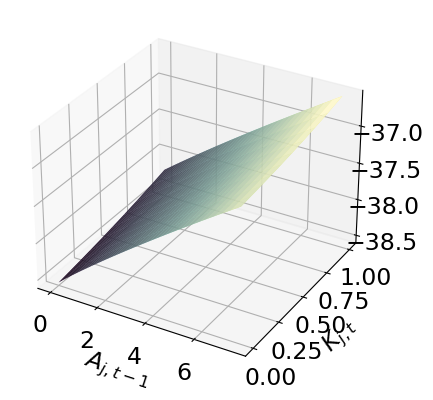

In [11]:
model_list = ('model_NC','model_LC','model_FC',)
# model_list = ('model 3, full',)
sol_type ='single'
par = models[model_list[0]].par
iZ = 0;
cmaps = ('viridis','gray')
for t in (0,):
    for var in ('V','cons','labor'):
        for sex in (1,2):
            sex_str = 'w' if sex==1 else 'm'
            if var not in ('V',):
                sex_str = f'_{sex_str}'
            var_now = var
            var_now += f'{sex_str}_{sol_type}'
            
            fig = plt.figure()
            ax = plt.axes(projection='3d')

            grid_A = par.grid_Aw if sex==1 else par.grid_Am
            X, Y = np.meshgrid(grid_A, par.grid_K,indexing='ij')
            
            for i,name in enumerate(model_list):
                model = models[name]
                
                Z = getattr(model.sol,var_now)[t,iZ]
                
                #Z = getattr(model.sol,var)[t,:,iL,:,iKw,iKm]
                
                alpha = 0.5 if name=='model 1' else 0.7
                ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
                
                ax.set(xlabel='$A_{j,t-1}$',ylabel='$K_{j,t}$');
                
            fig_name = f'sol {var_now} t{t}{sex_str}'
            plt.tight_layout()
            if SAVE: 
                plt.savefig(path+fig_name+'.pdf')
            else:
                ax.set(title=fig_name)

## Couples
Plot policy functions as a function of woman's power and household wealth

6.673367451192421


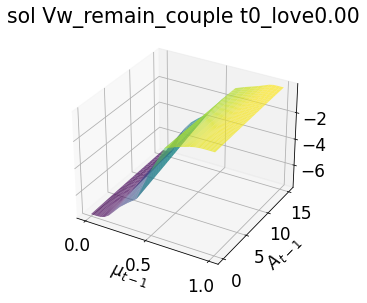

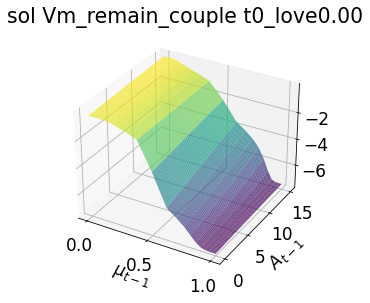

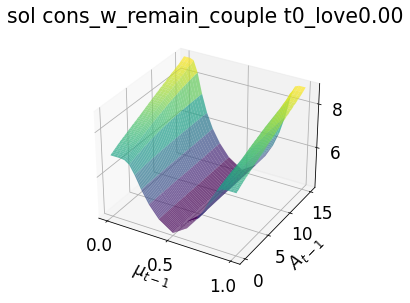

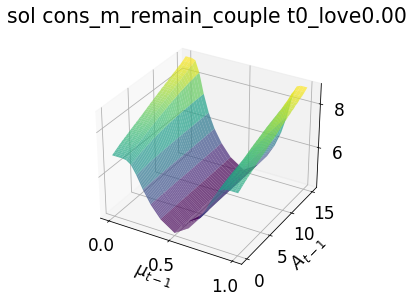

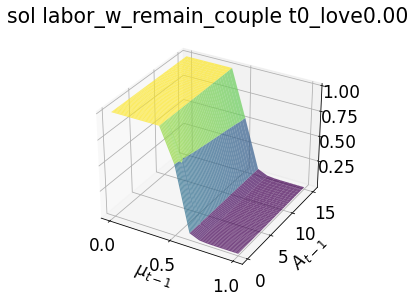

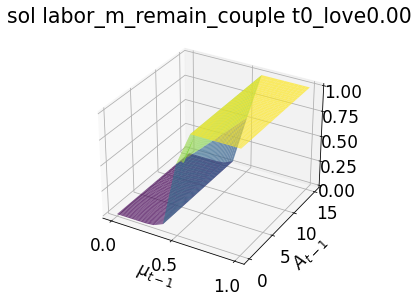

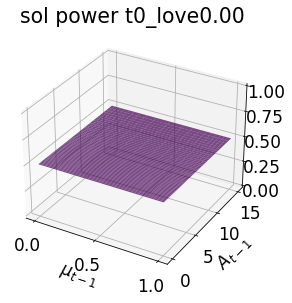

In [ ]:
model_list = ('model_NC','model_LC','model_FC',)
# model_list = ('model 3, full',)
sol_type ='remain_couple'
par = models[model_list[0]].par


t = 0
iK = 5
iKw = iK
iKm = iK

print(np.mean(model.sol.cons_w_remain_couple[t].ravel())) # 10.351192584353102 t=T-1, 8.307694301145856 at t=T-2

X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')
iZw = 0
iZm = 0
cmaps = ('viridis','gray')
for iL in (par.num_love//2,): 
    for var in ('Vw','Vm','cons_w','cons_m','labor_w','labor_m','power'):
        if var != 'power': 
            var += f'_{sol_type}'
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
            
            Z = getattr(model.sol,var)[t,iZw,iZm,:,iL,:,iKw,iKm]
            
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                ax.set(zlim=[0.0,1.0])
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: 
            plt.savefig(path+fig_name+'.pdf')
        else:
            ax.set(title=fig_name)

In [ ]:
print(np.mean(model.sol.EVw_pd.ravel())) # -0.2964800760720916 t=T-1

-3.7669735619317906


In [ ]:
# stop

# Simulated paths

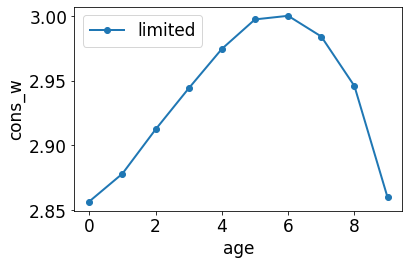

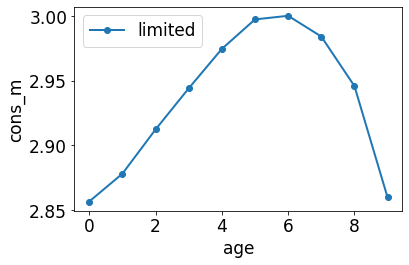

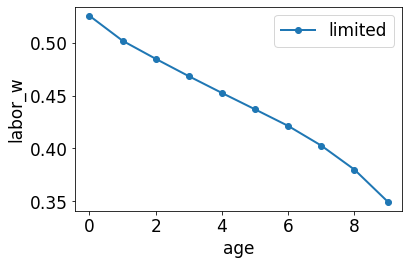

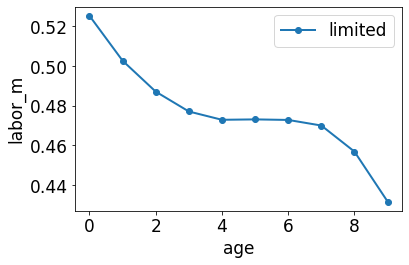

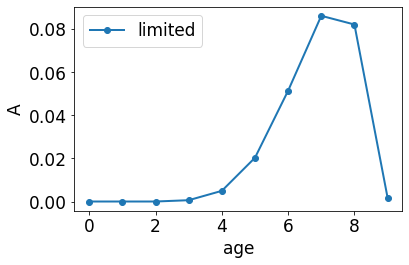

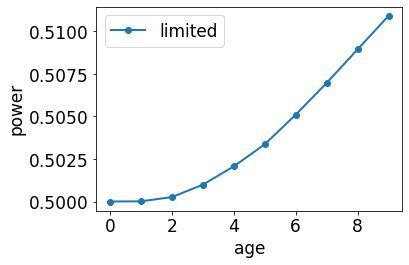

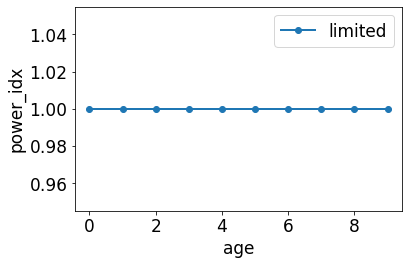

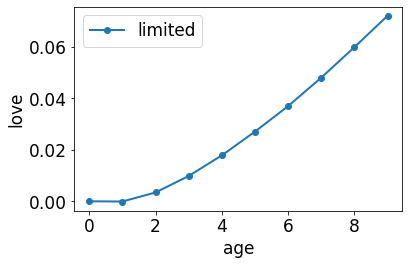

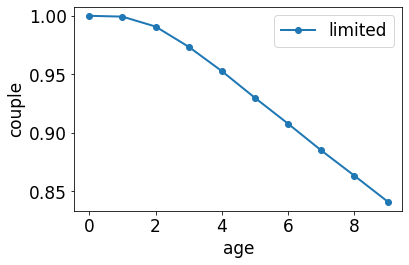

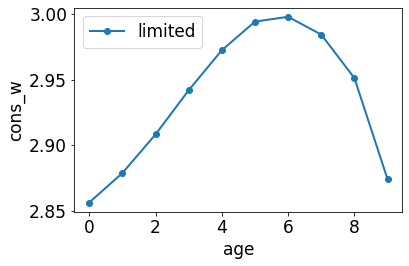

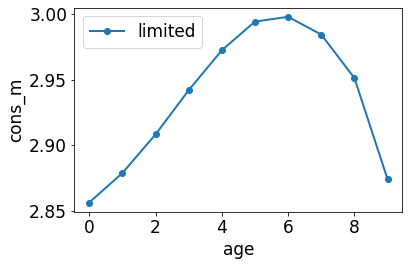

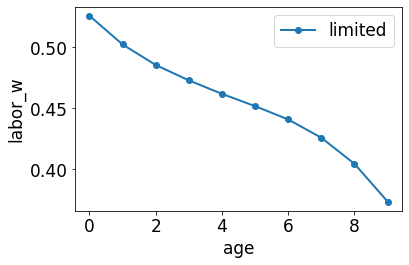

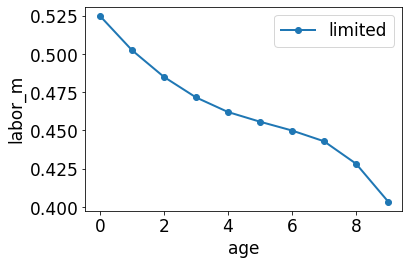

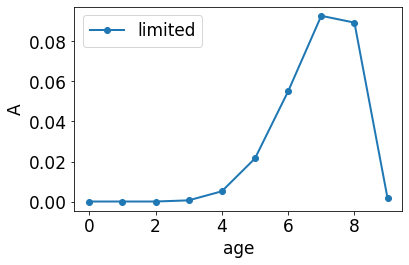

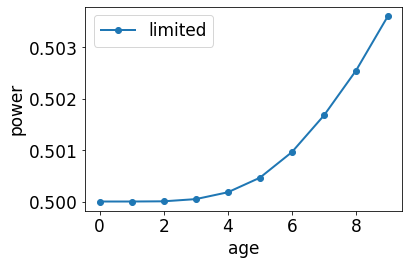

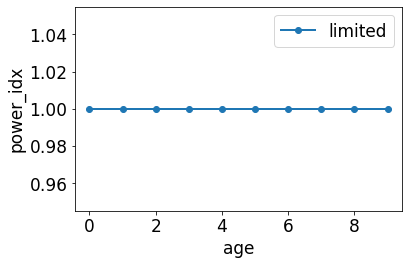

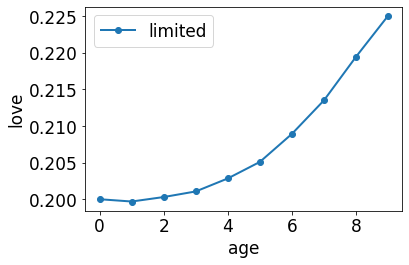

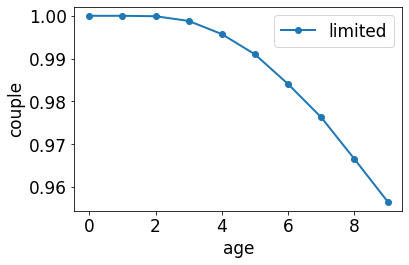

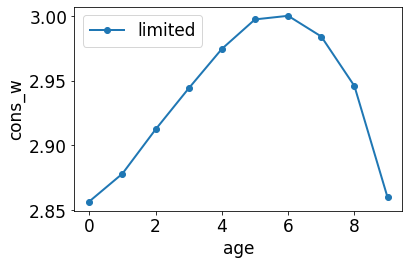

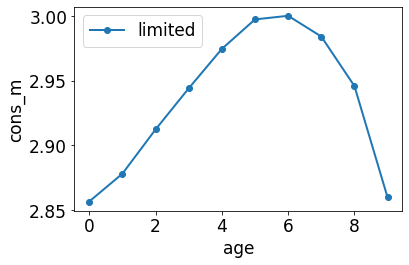

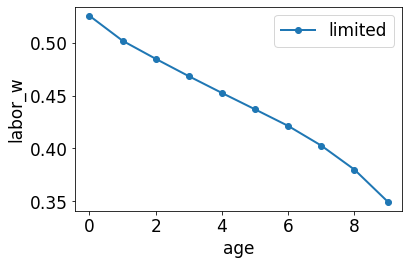

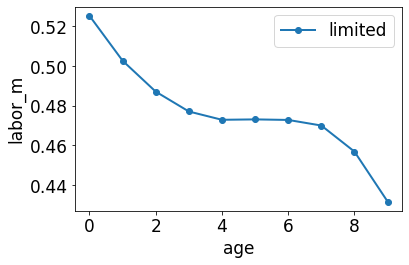

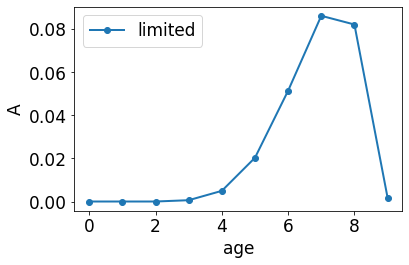

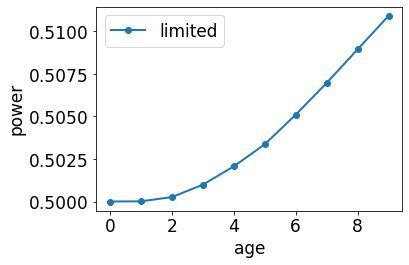

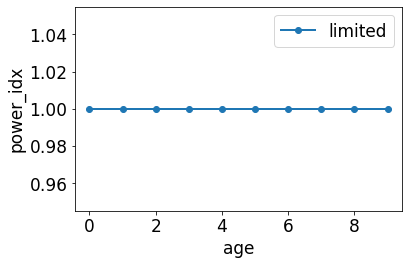

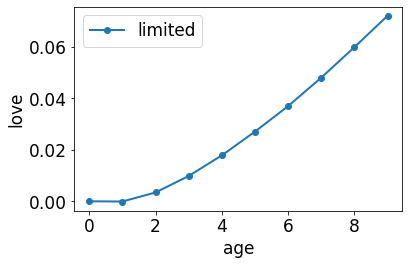

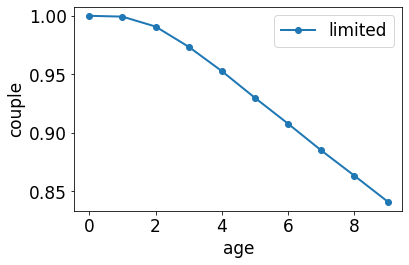

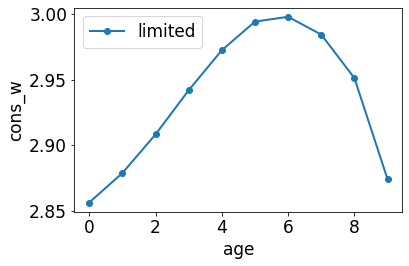

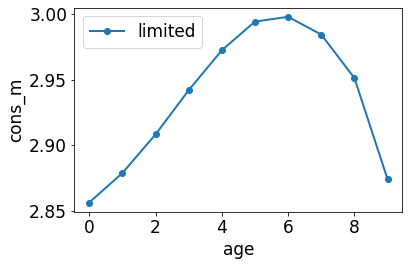

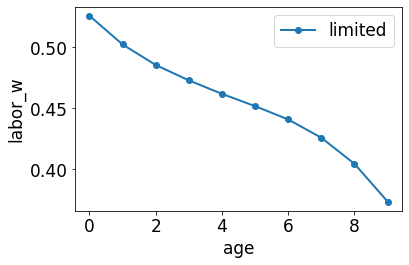

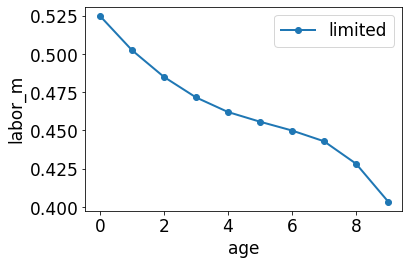

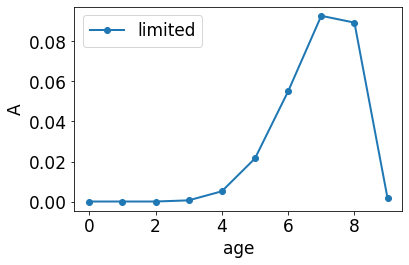

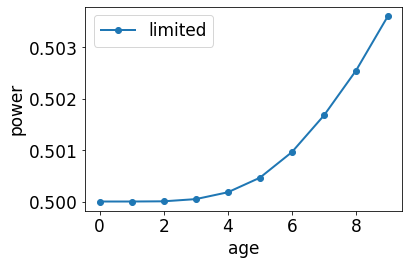

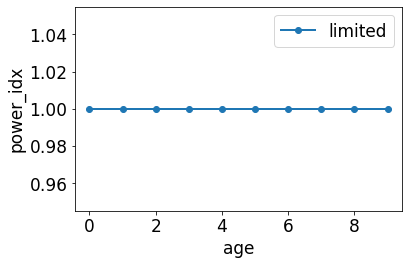

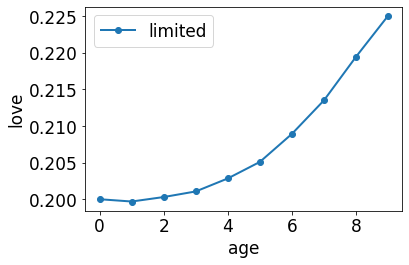

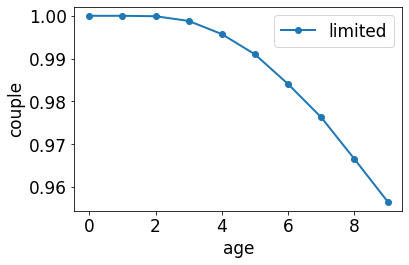

In [ ]:
SAVE = False
var_list = ('cons_w','cons_m','labor_w','labor_m','A','power','power_idx','love','couple')
model_list = ('model 3, limited','model 3, NASH','model 3, full' )
model_list = ('model 3, limited', )
# model_list = ('model 3, full','model 3, NASH')

for init_power_idx in (1,10):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')